In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D
from scipy.signal import butter, filtfilt
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
import time
from concurrent.futures import ProcessPoolExecutor
import dask.dataframe as dd
from numba import njit
plt.rcParams['figure.dpi'] = 150

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# LOAD THE DATA
df_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Print the data types of the columns in df_raw
df_raw.dtypes


Total Event no.        int64
Acc_x                float64
Acc_y                float64
Acc_z                float64
Mag_x                float64
Mag_y                float64
Mag_z                float64
Date                  object
DD                     int64
MM                     int64
YY                     int64
Time hh:mm:ss.ddd     object
Decimal secs         float64
Unnamed: 13          float64
dtype: object

In [4]:
# Print the data types of the columns in gps
gps.dtypes

Date                 object
Time                 object
location.lat        float64
location.long       float64
Height.above.msl    float64
UTM_E               float64
UTM_N               float64
Slope1              float64
dtype: object

In [5]:
# Convert date and time from text to datetime obj
df_raw['date_converted'] = pd.to_datetime(df_raw['Date'], format='%d/%m/%Y', errors='coerce')
df_raw['time_converted'] = pd.to_timedelta(df_raw['Time hh:mm:ss.ddd'])
df_raw['datetime'] = df_raw['date_converted'] + df_raw['time_converted']

gps['date_converted'] = pd.to_datetime(gps['Date'], format='%d/%m/%Y', errors='coerce')
gps['time_converted'] = pd.to_timedelta(gps['Time'])
gps['datetime'] = gps['date_converted'] + gps['time_converted']

In [6]:
# Print the data types of df_raw
df_raw.dtypes

Total Event no.                int64
Acc_x                        float64
Acc_y                        float64
Acc_z                        float64
Mag_x                        float64
Mag_y                        float64
Mag_z                        float64
Date                          object
DD                             int64
MM                             int64
YY                             int64
Time hh:mm:ss.ddd             object
Decimal secs                 float64
Unnamed: 13                  float64
date_converted        datetime64[ns]
time_converted       timedelta64[ns]
datetime              datetime64[ns]
dtype: object

In [7]:
# Print the data types of the columns in gps
gps.dtypes

Date                         object
Time                         object
location.lat                float64
location.long               float64
Height.above.msl            float64
UTM_E                       float64
UTM_N                       float64
Slope1                      float64
date_converted       datetime64[ns]
time_converted      timedelta64[ns]
datetime             datetime64[ns]
dtype: object

In [8]:
df_raw.head(20)

,Total Event no.,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,Date,DD,MM,YY,Time hh:mm:ss.ddd,Decimal secs,Unnamed: 13,date_converted,time_converted,datetime
0,22499780,-0.095947,-0.203857,-1.031980,-0.044678,0.060547,-0.270752,25/2/2019,25,2,2019,22:24:0.000,0.000,NaN,2019-02-25,0 days 22:24:00,2019-02-25 22:24:00.000
1,22499783,-0.107910,-0.179932,-0.911865,-0.049316,0.064209,-0.269775,25/2/2019,25,2,2019,22:24:0.076,0.076,NaN,2019-02-25,0 days 22:24:00.076000,2019-02-25 22:24:00.076
2,22499787,-0.035889,-0.083984,-0.899902,-0.041992,0.079834,-0.272461,25/2/2019,25,2,2019,22:24:0.179,0.179,NaN,2019-02-25,0 days 22:24:00.179000,2019-02-25 22:24:00.179
3,22499791,-0.227783,-0.239990,-1.187990,-0.037598,0.078613,-0.269043,25/2/2019,25,2,2019,22:24:0.282,0.282,NaN,2019-02-25,0 days 22:24:00.282000,2019-02-25 22:24:00.282
4,22499795,-0.203857,-0.275879,-1.127930,-0.045654,0.068359,-0.271484,25/2/2019,25,2,2019,22:24:0.384,0.384,NaN,2019-02-25,0 days 22:24:00.384000,2019-02-25 22:24:00.384
5,22499799,-0.059814,-0.251953,-1.019780,-0.036621,0.074463,-0.269775,25/2/2019,25,2,2019,22:24:0.487,0.487,NaN,2019-02-25,0 days 22:24:00.487000,2019-02-25 22:24:00.487
6,22499803,0.011963,-0.191895,-0.875977,-0.020264,0.079590,-0.271484,25/2/2019,25,2,2019,22:24:0.589,0.589,NaN,2019-02-25,0 days 22:24:00.589000,2019-02-25 22:24:00.589
7,22499807,-0.023926,-0.179932,-0.899902,-0.029541,0.075684,-0.271484,25/2/2019,25,2,2019,22:24:0.692,0.692,NaN,2019-02-25,0 days 22:24:00.692000,2019-02-25 22:24:00.692
8,22499811,-0.023926,-0.215820,-1.031980,-0.034424,0.070312,-0.271484,25/2/2019,25,2,2019,22:24:0.794,0.794,NaN,2019-02-25,0 days 22:24:00.794000,2019-02-25 22:24:00.794
9,22499815,-0.095947,-0.263916,-0.983887,-0.033936,0.063965,-0.272217,25/2/2019,25,2,2019,22:24:0.897,0.897,NaN,2019-02-25,0 days 22:24:00.897000,2019-02-25 22:24:00.897


In [9]:
# Extract the Acc_x, Acc_y, Acc_z, and datetime columns from df raw
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'datetime']]


In [10]:
# Merge df_raw and gps using a left join on the datetime column
df_raw = pd.merge(df_raw,gps,on='datetime',how='left')

In [11]:
# To make the code run faster while you're still learning, we're going to filter the data to a six hour time window

# Define start and end time
start_time = '2019-02-26 03:00:00'
end_time = '2019-02-26 09:00:00'

# Filter dataframe for records between the start and end time
df = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)].reset_index()

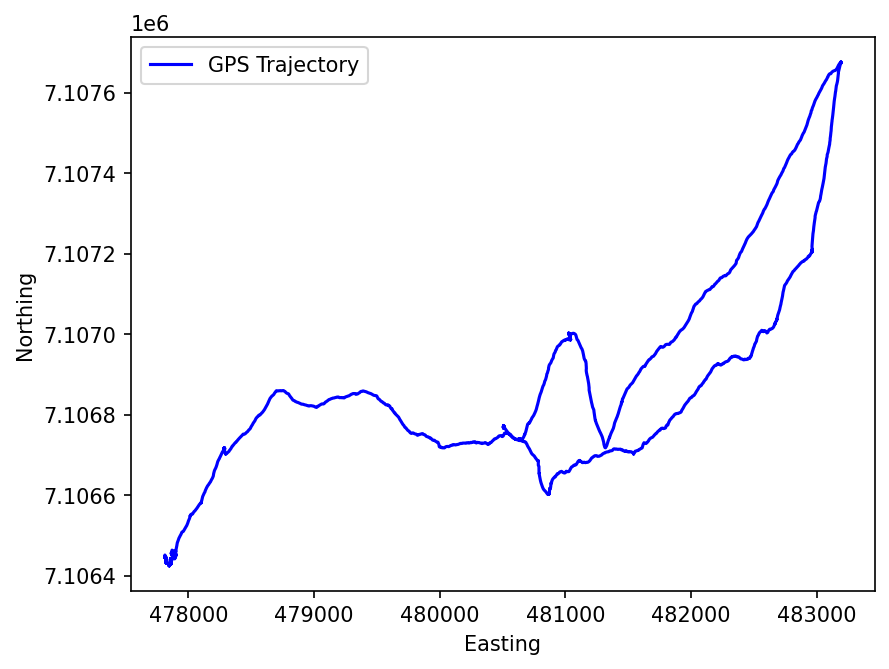

In [12]:
# PLOT GPS TRAJECTORY OF THE ANIMAL

# Make a dataframe for plotting
# Here we are defining a variables called "gps_pts" that is a copy of the "df" dataframe that is filtered for records where the 
# UTM coordinates are not null
gps_pts = df.copy()[df['UTM_E'].notnull()]

# Define x and y data
x = gps_pts['UTM_E']
y = gps_pts['UTM_N']

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(x, y,  color='b', label = "GPS Trajectory")

# Setting labels
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Adding a title and legend
ax.legend()

# Show plot
plt.show()

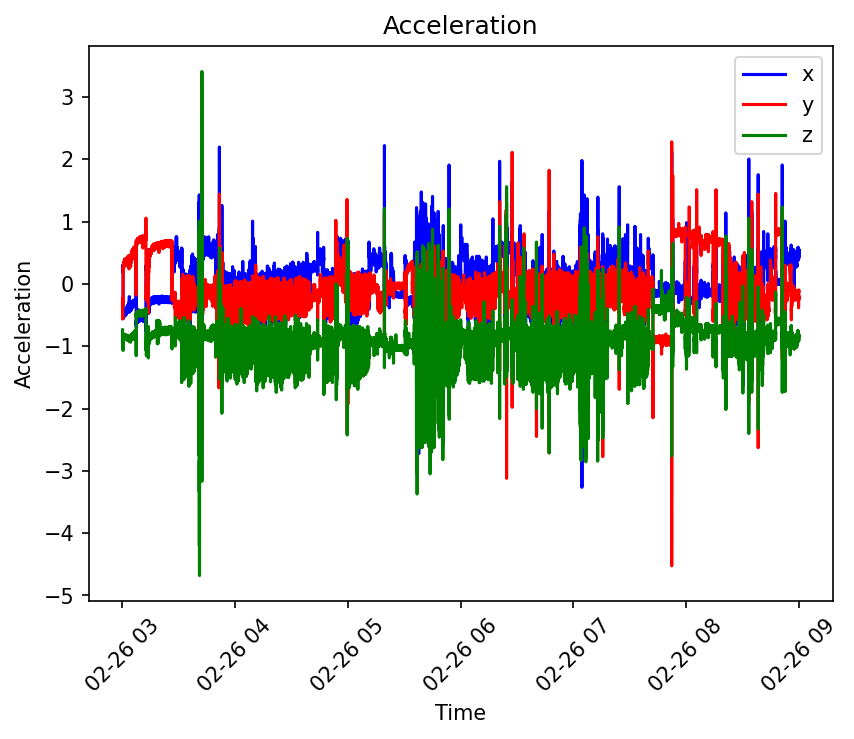

In [13]:
# PLOT ACCELERATION OVER TIME

# Define data for plotting
Acc_x = df['Acc_x']
Acc_y = df['Acc_y']
Acc_z = df['Acc_z']
dt = df['datetime']

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the acceleration data
ax.plot(dt, Acc_x, linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y,  linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z,  linestyle='-', color='g', label='z')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

## Step 1: Remove effects of pitch and roll

In [14]:
# DESIGN THE BUTTERWORTH FILTER FOR CALCULATING STATIC ACCELERATION

# Define the parameters of the butterworth filter
# Parameters are taken directly from the text in Ladha 2018
order = 4  # We are designing a 4th order butterworth filter
cutoff_frequency = 0.5  # Wc in Ladha 2018. This is the cutoff frequency in Hz. A cutoff freq of 0.5 means that frequencies higher than 0.5 Hz 
# will get filtered out. Ladha 2018 uses a Wc of 0.1, but we will use 0.5.
sampling_rate = 10  # Sampling rate in Hz. This should be equal to the sampling rate of the accelerometery data which in our case is 10 Hz.

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [15]:
# Apply the butterworth filter to calculate static acceleration in X,Y,and Z
df['Gx'] = filtfilt(b, a, df['Acc_x'])
df['Gy'] = filtfilt(b, a, df['Acc_y'])
df['Gz'] = filtfilt(b, a, df['Acc_z'])

# Calculate Dynamic Acceleration in X,Y,and Z
df['DAx'] = df['Acc_x'] - df['Gx']
df['DAy'] = df['Acc_y'] - df['Gy']
df['DAz'] = df['Acc_z'] - df['Gz']

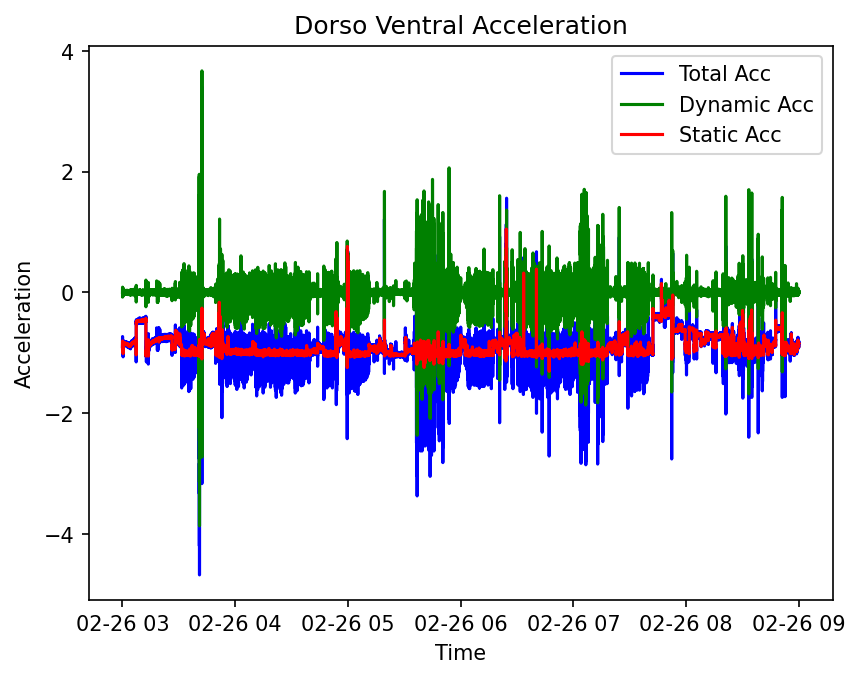

In [16]:
# Plot dynamic and static accleration in the dorsoventral (z) axis

# Get data for plotting
Acc_z = df['Acc_z'] # raw data
Gz = df['Gz'] # static acceleration
DAz = df['DAz'] # dynamic acceleration
dt = df['datetime']

# Initalize the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_z,  linestyle='-', color='b', label='Total Acc')
ax.plot(dt, DAz, linestyle = '-', color = 'g', label = 'Dynamic Acc')
ax.plot(dt, Gz,  linestyle='-', color='r', label='Static Acc')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Dorso Ventral Acceleration')
ax.legend()

# Show plot
plt.show()

In [17]:
# COMPUTE PITCH AND ROLL

# Get static acceleration
Gx = np.array(df['Gx'])
Gy = np.array(df['Gy'])
Gz = np.array(df['Gz'])

# Compute pitch (radians)
pitch = np.arctan2(Gx,np.sqrt(Gy**2 + Gz**2))
df['pitch'] = pitch

# Compute roll (radians)
roll =  np.arctan2(Gy,np.sqrt(Gx**2 + Gz**2))
df['roll'] = roll

In [18]:
# BUILD ROTATION MATRICES

# Define a function to build the pitch rotation matrices
def get_Rx(pitch_values):
    cos_pitch = np.cos(pitch_values)
    sin_pitch = np.sin(pitch_values)

    # Create an empty array to hold the rotation matrices
    # Shape: (n, 3, 3) where n is the number of pitch values
    rotation_matrices = np.zeros((pitch_values.shape[0], 3, 3))

    # Fill in the rotation matrices
    rotation_matrices[:, 0, 0] = 1  # First row, first column is always 1
    rotation_matrices[:, 1, 1] = cos_pitch  # cos(pitch) in second row, second column
    rotation_matrices[:, 1, 2] = sin_pitch  # sin(pitch) in second row, third column
    rotation_matrices[:, 2, 1] = -sin_pitch # -sin(pitch) in third row, second column
    rotation_matrices[:, 2, 2] = cos_pitch  # cos(pitch) in third row, third column

    return rotation_matrices

# Build pitch rotation matrices using calculated pitch values
Rx = get_Rx(pitch)

# Define a function to build the roll rotation matrices
def get_Ry(roll_values):
    cos_roll = np.cos(roll_values)
    sin_roll = np.sin(roll_values)

    # Create an empty array to hold the rotation matrices
    # Shape: (n, 3, 3) where n is the number of roll values
    rotation_matrices = np.zeros((roll_values.shape[0], 3, 3))

    # Fill in the rotation matrices
    rotation_matrices[:, 0, 0] = cos_roll  # cos(roll) in first row, first column
    rotation_matrices[:, 0, 2] = sin_roll  # sin(roll) in first row, third column
    rotation_matrices[:, 1, 1] = 1         # 1 in the second row, second column
    rotation_matrices[:, 2, 0] = -sin_roll # -sin(roll) in third row, first column
    rotation_matrices[:, 2, 2] = cos_roll  # cos(roll) in third row, third column

    return rotation_matrices

# Build roll rotation matrices using calculated roll values
Ry = get_Ry(roll)

# Get array of raw acceleration
Acc = np.asarray(df[['Acc_x','Acc_y','Acc_z']])

# Remove the effects of pitch by multiplying the accelerometer data by the pitch rotation matrices
pitch_corrected_data = np.einsum('ijk,ik->ij', Rx, Acc)

# Remove the effects of roll by multiplying the pitch-corrected data by the roll rotation matrices
pitch_and_roll_corrected_data = np.einsum('ijk,ik->ij', Ry,pitch_corrected_data)

# Convert from numpy to pandas and add the data to the "df" dataframe
rotated_data = pitch_and_roll_corrected_data
rotated_data_df = pd.DataFrame(rotated_data, columns=['RAx', 'RAy', 'RAz'])
df['RAx'] = rotated_data_df['RAx']
df['RAy'] = rotated_data_df['RAy']
df['RAz'] = rotated_data_df['RAz']

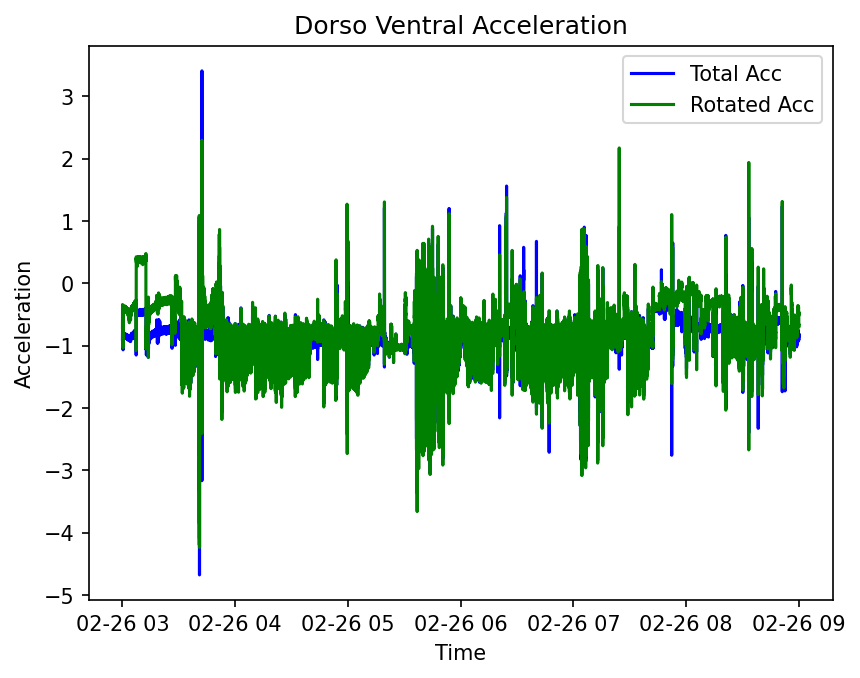

In [19]:
# Visualize effect of applying pitch and roll corrections to dorsoventral accelerometery data

# Get data for plotting
Acc_z = df['Acc_z'] # raw data
RAz = df['RAz'] # rotated data
dt = df['datetime']

# Initalize the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_z,  linestyle='-', color='b', label='Total Acc')
ax.plot(dt, RAz, linestyle = '-', color = 'g', label = 'Rotated Acc')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Dorso Ventral Acceleration')
ax.legend()

# Show plot
plt.show()


## Step 2: Identify candidate steps using dynamic threshold on filtered DV axis

In [20]:
# DESIGN THE BUTTERWORTH FILTER
# Purpose of this butterworth filter is to filter out noise in the Acc data

# Parameters
order = 4  # 4th order
cutoff_frequency = 4.75  # Cutoff frequency in Hz (Wc). Here 
sampling_rate = 10  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [21]:
# Apply the butterworth filter to the rotated X,Y,and Z accelerometery data
# Store the filtered and rotated data as columns called 'FRAx', 'FRAy', and 'FRAz' in df
df['FRAx'] = filtfilt(b, a, df['RAx'])
df['FRAy'] = filtfilt(b, a, df['RAy'])
df['FRAz'] = filtfilt(b, a, df['RAz'])

In [22]:
# Compute the magnitude of acceleration using FRAx, FRAy, and FRAz
# Store this in a column called 'magnitude'
# We are going to use the magnitude of acceleration to define periods when the animal is active

df['FRAx'] = pd.to_numeric(df['FRAx'], errors='coerce')
df['FRAy'] = pd.to_numeric(df['FRAy'], errors='coerce')
df['FRAz'] = pd.to_numeric(df['FRAz'], errors='coerce')
df['magnitude'] = np.sqrt(df['FRAx']**2 + df['FRAy']**2 + df['FRAz']**2)

In [23]:
# Calculate the standard deviation of the magnitude of accleration using a rolling window of 50
# The standard deviation will tell us how variable the acceleration is within a window of 5 seconds (50 records)
# When the animal is active, the standard deviation should be high

window_size = 50 # 5 Seconds
df['mag_sd'] = df['magnitude'].rolling(window=window_size).std()

In [24]:
# Define a threshold for classifying activity based on standard deviation
sd_threshold = 0.01 # standard deviations

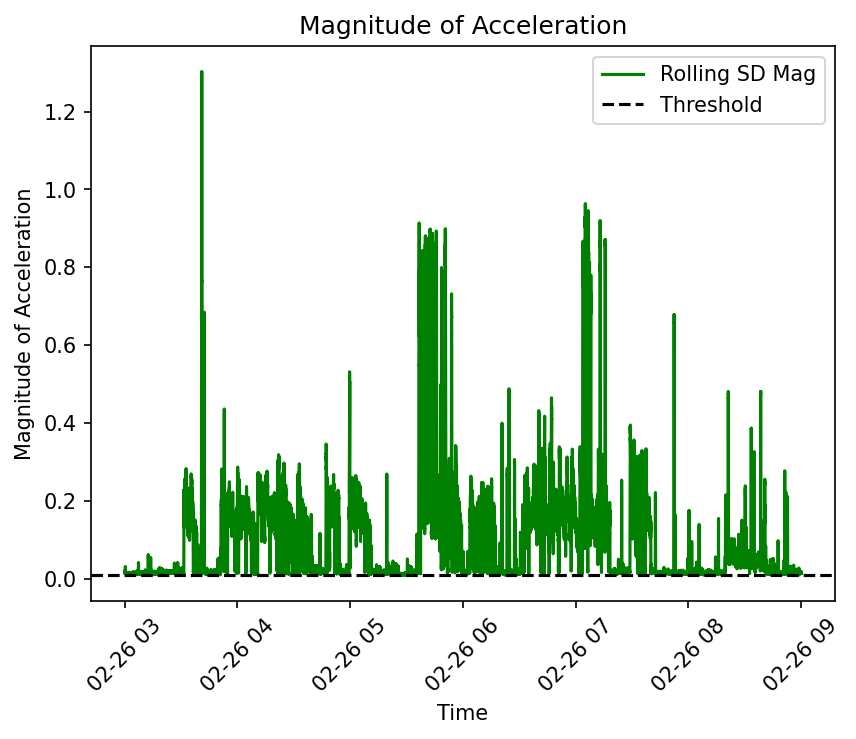

In [25]:
# Plot the standard deviation of the magnitude of accleration
dt = df['datetime']
mag_sd = df['mag_sd']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt,mag_sd,linestyle="-", color = "g", label = "Rolling SD Mag")
plt.axhline(y=sd_threshold, color='black', linestyle='--', label='Threshold')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude of Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Magnitude of Acceleration')
ax.legend()

# Show plot
plt.show()

In [26]:
# Split activity periods into groups based on SD threshold
above_sd_threshold = np.array(df['mag_sd']) > sd_threshold
sd_threshold_change = np.append([False],above_sd_threshold[:-1] != above_sd_threshold[1:])
activity_group = np.cumsum(sd_threshold_change)
df['activity_group'] = activity_group

# Assign activity status based on SD threshold
df['active'] = above_sd_threshold

# Get rid of small groups (activity periods < 20s)
group_counts = df.groupby('activity_group').size().reset_index(name='Count')
small_groups = group_counts.loc[group_counts['Count']<=200,'activity_group'].values
df.loc[df['activity_group'].isin(small_groups), 'active'] = 0

In [27]:
# Make a new dataframe with only data 
#from when the animal was active (as defined by the magnitude of acceleration threshold)
active_periods = df.copy()[df['active']==1].reset_index()

## Step 3: Identify step candidates using a dynamic threshold on the filterd DV (dorso-ventral) axis
The code for this portion is based on the methods in the dog step count paper

In [28]:
#Set the timestamp as the index
active_periods.set_index('datetime', drop = False, inplace = True) 

# Initialize zero threshold column
active_periods['thresh_z'] = -999

# Initialize falling flank column
active_periods['falling_edges'] = False

In [29]:
# Get a list of activity groups

activity_groups = active_periods.loc[active_periods['active']==1,'activity_group'].unique()
num_groups = len(activity_groups)

# Derive zero threshold for each activity group using 20s windows

for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    
    # calculate zero threshold
    for window_start in group_data.resample('20S').groups:
    
        window_data = group_data.loc[window_start:window_start + pd.Timedelta(seconds=20)]
    
        # Identify mean of max peak and min nadir in each window for acc in z axis
        signal = window_data['FRAz'].values
        max_z = signal.max()
        min_z = signal.min()
        thresh = (max_z + min_z)/2
        window_data['thresh_z'] = thresh
    
        # Identify falling flanks that cross the zero threshold 
        
        falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
        window_data['falling_edges'].iloc[1:] = falling_edges
    
        group_data.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data

    # Join group data back to complete dataset
    active_periods[active_periods['activity_group'] == group] = group_data

In [30]:
active_periods.columns

Index(['level_0', 'index', 'Acc_x', 'Acc_y', 'Acc_z', 'datetime', 'Date',
       'Time', 'location.lat', 'location.long', 'Height.above.msl', 'UTM_E',
       'UTM_N', 'Slope1', 'date_converted', 'time_converted', 'Gx', 'Gy', 'Gz',
       'DAx', 'DAy', 'DAz', 'pitch', 'roll', 'RAx', 'RAy', 'RAz', 'FRAx',
       'FRAy', 'FRAz', 'magnitude', 'mag_sd', 'activity_group', 'active',
       'thresh_z', 'falling_edges'],
      dtype='object')

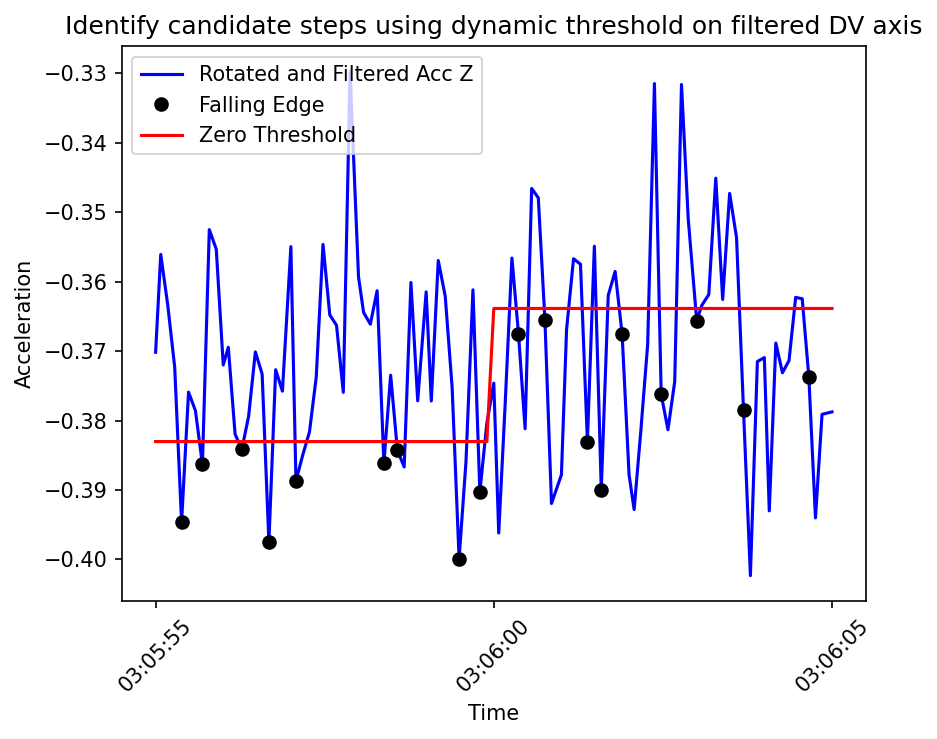

In [31]:
# Plot of dynamic threshold used to idenitfy step candidates
# I've zoomed in on a small portion of the time series so you can actually see what it looks like

# Initialize the pltot
fig = plt.figure()
ax = fig.add_subplot(111)

# Get a small subset of the data to visualize
DV_plot_data = active_periods.copy()[(active_periods['datetime'] >= '2019-02-26 3:05:55') & (active_periods['datetime'] <= '2019-02-26 3:06:05')]
DV_plot_groups = DV_plot_data.loc[DV_plot_data['active']==1,'activity_group'].unique()
num_DV_plot_groups = len(DV_plot_groups)

# Add data by group
for i in range(0,num_DV_plot_groups):

    # get group number
    group = DV_plot_groups[i]
    
    # get group data
    group_data = DV_plot_data[DV_plot_data['activity_group'] == group]
    
    # Get data for plotting
    FRAz = group_data['FRAz']
    thresh_z = group_data['thresh_z']
    dt = group_data['datetime']
    dt_falling_edges = group_data[DV_plot_data['falling_edges'] == True]['datetime']
    falling_edges = group_data[DV_plot_data['falling_edges'] == True]['FRAz']

    # Plot the data
    ax.plot(dt, FRAz, linestyle='-', color='b', label='Rotated and Filtered Acc Z')
    ax.plot(dt_falling_edges, falling_edges, marker = "o",linestyle='', color='black', label='Falling Edge')
    ax.plot(dt, thresh_z,  linestyle='-', color='r', label='Zero Threshold')

    # Add legend
    if i == 0:
        ax.legend()

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Identify candidate steps using dynamic threshold on filtered DV axis')

# Show plot
plt.show()

## Step 4: Reject candidates based on step frequency

In [32]:
# Initialize dataframe to store step candidates
cols = list(df.columns) + ['elapsed_time'] 
step_candidates = pd.DataFrame(columns=cols)


# Get step candidates from each activity period and append them to the step_candidates dataframe
for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]

    # Filter group data for step candidates
    step_candidates_by_group = group_data[group_data['falling_edges'] == True]

    # Compute time between candidates
    step_candidates_by_group['elapsed_time'] = step_candidates_by_group['datetime'].diff().apply(lambda x: x.total_seconds()) 

    # Populate 'activity_group' column of step_candidates dataframe
    step_candidates_by_group['activity_group'] = group

    # Join step candidates from each group to main step candidates table
    step_candidates = pd.concat([step_candidates,step_candidates_by_group],ignore_index=True)

In [33]:
# Reset indices of step_candidates and df
active_periods['rowID'] = range(0,len(active_periods))
step_candidates['rowID'] = range(0,len(step_candidates))
active_periods.set_index('rowID', inplace = True) 
step_candidates.set_index('rowID', inplace = True) 

In [34]:
# Set valid step frequencies
min_stride_freq = 0.5
max_stride_freq = 1.95
min_period = 1/max_stride_freq
max_period = 1/min_stride_freq

In [35]:
# Filter out false steps based on range of valid step frequencies
obs_freq = np.array(step_candidates['elapsed_time'])
valid_steps = (obs_freq >= min_period) & (obs_freq<= max_period)
step_candidates['valid_step'] = valid_steps
step_candidates = step_candidates[['valid_step','datetime','activity_group']]
step_candidates = step_candidates[step_candidates['valid_step'] == True].reset_index()

In [36]:
# Join step candidates back to original df
active_periods = pd.merge(step_candidates[['valid_step','datetime']],active_periods,on = 'datetime', how='right')

## Step 5: Estimate Distance Traveled

In [37]:
# ESTIMATE DISTANCE TRAVELED FROM THE ACC DATA

# Initialize distance traveled column
step_candidates['distance_traveled'] = np.nan

# Create a list of DataFrames, each one filtered by an activity group
dfs = [step_candidates[step_candidates['activity_group'] == group] for group in activity_groups]

# Create a Dask DataFrame from the list of pandas DataFrames
step_candidates_dask = dd.from_pandas(pd.concat(dfs), npartitions=len(dfs))

def calculate_distance(group_step_candidates, active_periods):
    # Reset index to use standard indexing
    group_step_candidates = group_step_candidates.reset_index(drop=True)
    
    # Initialize 'distance_traveled' column
    group_step_candidates['distance_traveled'] = np.nan

    # Calculate start and end times for strides
    start_times = group_step_candidates['datetime'].shift(1).dropna()
    end_times = group_step_candidates['datetime'].shift(-1).dropna()

    # Filter out stride data that has valid start and end times
    valid_indices = ~start_times.isna() & ~end_times.isna()
    start_times = start_times[valid_indices]
    end_times = end_times[valid_indices]

    def compute_distance(start_time, end_time):
        stride_data = active_periods[(active_periods['datetime'] >= start_time) & (active_periods['datetime'] <= end_time)]
        if stride_data.empty:
            return 0
        max_acc = stride_data['RAz'].max()
        min_acc = stride_data['RAz'].min()
        return (max_acc - min_acc)**0.25

    distances = [compute_distance(start, end) for start, end in zip(start_times, end_times)]

    # Fill the distances into the group_step_candidates
    group_step_candidates['distance_traveled'] = np.nan
    group_step_candidates.iloc[1:-1, group_step_candidates.columns.get_loc('distance_traveled')] = distances

    # Fill NaN values with 0
    group_step_candidates['distance_traveled'] = group_step_candidates['distance_traveled'].fillna(0)
    
    return group_step_candidates

# Define the meta DataFrame to ensure Dask knows the structure of the result
meta = step_candidates.iloc[:0]  # Empty dataframe with correct columns

# Apply the function to each group
# Ensure active_periods is passed explicitly as an argument
result_dask_df = step_candidates_dask.map_partitions(calculate_distance, active_periods, meta=meta)

# Compute the result
start_time = time.time()
result_df = result_dask_df.compute()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(result_df)

# Fill in NaN distance_traveled with 0
result_df['distance_traveled'] = result_df['distance_traveled'].fillna(0)

# Calculate cumulative distance traveled
result_df['cum_dist'] = result_df['distance_traveled'].cumsum()
step_candidates = result_df 

Elapsed time: 11.264799 seconds
     rowID  valid_step                datetime activity_group  \
0        1        True 2019-02-26 03:00:09.384              1   
1        3        True 2019-02-26 03:00:10.756              1   
2        4        True 2019-02-26 03:00:11.384              1   
3        7        True 2019-02-26 03:00:12.675              1   
4       11        True 2019-02-26 03:00:14.658              1   
..     ...         ...                     ...            ...   
385  25563        True 2019-02-26 08:59:14.170            189   
386  25567        True 2019-02-26 08:59:16.175            189   
387  25568        True 2019-02-26 08:59:17.000            189   
388  25573        True 2019-02-26 08:59:19.179            189   
389  25574        True 2019-02-26 08:59:19.794            189   

     distance_traveled  
0             0.000000  
1             0.498210  
2             0.530362  
3             0.526842  
4             0.507634  
..                 ...  
385         

In [38]:
# ESTIMATE DISTANCE TRAVELED FROM THE GPS DATA

# Define start and end pts of each step
x0 = gps_pts['UTM_E'].iloc[:-1].values
x1 = gps_pts['UTM_E'].iloc[1:].values
y0 = gps_pts['UTM_N'].iloc[:-1].values
y1 = gps_pts['UTM_N'].iloc[1:].values

# Calculate x1-x0 and y1-y0
x_diff = x1-x0
y_diff = y1-y0

# Compute (x1-x0)^2 and (y1-y0)^2
x_diff_sqr = x_diff*x_diff
y_diff_sqr = y_diff*y_diff

# Compute (x1-x0)^2 + (y1-y0)^2
xy_diff_sqr_sum = x_diff_sqr + y_diff_sqr

# Compute ((x1-x0)^2 + (y1-y0)^2)^0.5
euclidean_distance_step = [math.sqrt(x) for x in xy_diff_sqr_sum]
euclidean_distance_step = np.append([0],euclidean_distance_step)
gps_pts['euclidean_distance_step'] = euclidean_distance_step

# Add error bounds assuming gps error is 0.5m
error = 0.5
gps_dist_lwr = np.maximum(0, np.array(euclidean_distance_step) - 2 * error)
gps_dist_upr = np.array(euclidean_distance_step) + 2 * error

# Compute total distance travel
gps_pts['cum_dist'] = gps_pts['euclidean_distance_step'].cumsum()
gps_pts['cumsum_lwr'] = np.cumsum(gps_dist_lwr)
gps_pts['cumsum_upr'] = np.cumsum(gps_dist_upr)

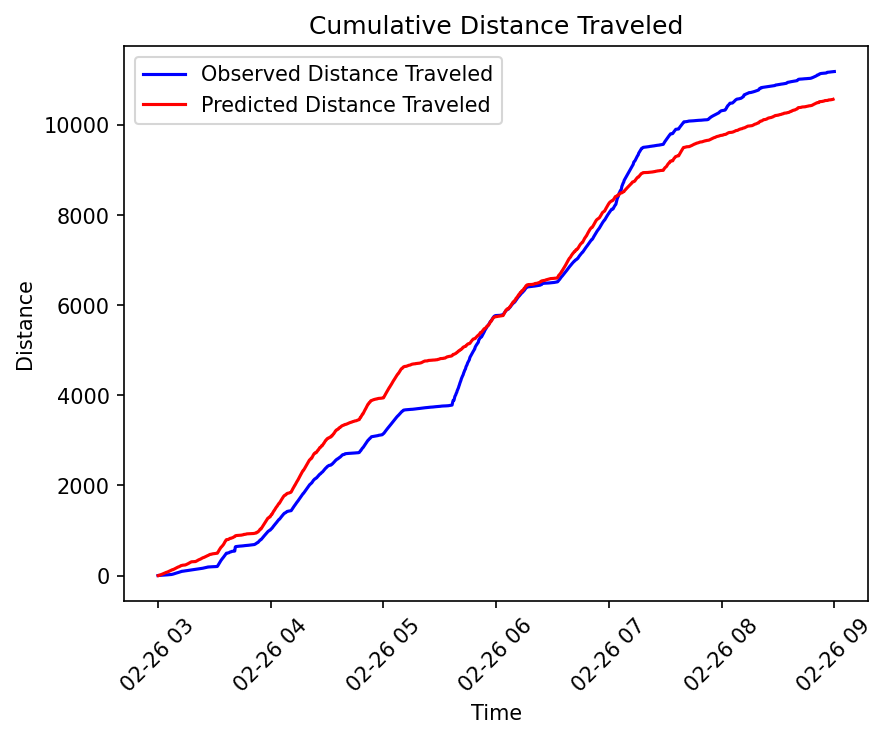

In [39]:
# Plot cumulative distance traveled as estimated from the  acc and GPS data
obs_dist = gps_pts['cum_dist']
obs_dt = gps_pts['datetime']
pred_dist = result_df['cum_dist']
pred_dt = result_df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_dist, linestyle='-', color='b', label='Observed Distance Traveled')
ax.plot(pred_dt, pred_dist,linestyle='-', color='r', label='Predicted Distance Traveled')
#plt.fill_between(obs_dt, gps_pts['cumsum_lwr'], gps_pts['cumsum_upr'])

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Distance')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Cumulative Distance Traveled')
ax.legend()

# Show plot
plt.show()

## Step 6: Estimate ground slope

Using trig, we can say that ground slope can be approximated as: ground slope = arcsin(Gx/9.81)-collar angle

$$
\text{slope of the ground} = \arcsin\left(\frac{\text{Gx}}{9.81}\right) - \text{collar angle}
$$

where:
- **Gx** refers to the component of acceleration due to gravity detected by the accelerometer along the longitudinal axis of the object (aligned with the ground slope).
- **9.81** represents the gravitational acceleration constant (in m/s²).
- **Collar Angle** is the angle of tilt of the accelerometer relative to the horizontal plane.

#### Step-by-Step Explanation

1. **Static Acceleration Along the Slope**:
   - When an object (like a vehicle or animal) is on a sloped surface, part of gravitational acceleration acts along the incline, while the rest acts perpendicular to it. The component of gravity along the slope (which the accelerometer detects as "static acceleration") changes depending on the slope angle, becoming larger as the slope increases.

2. **Calculating Slope from Static Acceleration**:
   - If we assume the object is stationary or moving at a constant velocity, the acceleration sensed along the slope is due to gravity alone. The component of gravitational acceleration along the slope can be described as:
     $$
     \text{static acceleration} = 9.81 \times \sin(\text{slope angle})
     $$
   - Solving for the slope angle, we get:
     $$
     \text{slope angle} = \arcsin\left(\frac{\text{static acceleration}}{9.81}\right)
     $$

3. **Adjusting for Pitch Angle**:
   - The **pitch angle** measures the tilt of the object relative to the horizontal. If the object is tilted (pitched up or down), the sensed static acceleration will be affected by this angle. To isolate the slope of the ground itself, we subtract the collar angle from the calculated angle:
     $$
     \text{slope of the ground} = \arcsin\left(\frac{\text{static acceleration}}{9.81}\right) - \text{collar angle}
     $$


We don't know the collar angle, but we do know Gx and can get the observed slope of the ground (from the gps data). This means that we can use an optimaization algorithm (in our case differential evolution) to estiamte what the collar angle is.


In [40]:
# Calc elevation change in GPS data using height above msl
gps_pts['delta_elev_msl'] = gps_pts['Height.above.msl'].diff()
gps_pts['cum_delta_elev_msl'] = gps_pts['delta_elev_msl'].cumsum()

In [41]:
# Merge step candidates with active_periods to get distance traveled
# Because the GPS data is at 1 second resoltuion, we need to average the acc data to get it to the same resoltuion
dists_slopes = pd.merge(active_periods, step_candidates[['distance_traveled','datetime']], on='datetime', how='left')
dists_slopes['date_floor'] = dists_slopes['datetime'].dt.floor('S')
dists_slopes = dists_slopes.groupby('date_floor').agg({
    'distance_traveled': 'sum',   # Sum of 'value1'
    'RAx': 'mean',
    'Gx': 'mean',
    'activity_group':'first'
}).reset_index()

dists_slopes = dists_slopes.rename(columns={'date_floor' : 'datetime'})
dists_slopes = pd.merge(dists_slopes, gps_pts[['delta_elev_msl','datetime','cum_delta_elev_msl']], on = "datetime", how = "left")
dists_slopes['distance_traveled'] = dists_slopes['distance_traveled'].fillna(0)

In [42]:
# Define a model predictions function that will be used by the optimization aglorithm

def model_predictions(collar_angle,data):

    # Predict slope
    ax = np.array(data['RAx'])
    gx = np.array(data['Gx'])
    data['slope_trig'] = np.arcsin((gx)/9.81)-collar_angle
    pred_slope = data['slope_trig']

    # Predict elevation change
    dist = np.array(data['distance_traveled'])
    slope = np.array(data['slope_trig'])    
    delta_elev = dist * np.tan(slope)
    return delta_elev

# Define the cost and objectie functions for the optimization aglorithm
def cost_function(params, data, actual):
    predictions = model_predictions(params, data)
    residuals = actual-predictions
    return np.sum((residuals)**2)

def objective(params):
    return cost_function(params,data,actual)

# Define perameter bounds for Differential Evolution (a type of genetic algorithm)
bounds = [(-0.008,-0.0065)] #  rangle of possible collar angles

In [43]:
# Perform the optimization

# Initialize columns for change in elevation and slope as predicted by the accelerometer
dists_slopes['delta_elev_acc']=-999
dists_slopes['slope_acc']=-999

# Find optimal parameters for each activity period and estimate slope

for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = dists_slopes[dists_slopes['activity_group'] == group]
    data = group_data
    actual = group_data['delta_elev_msl']

    # Run differential evolution aglorithm to estimate optimal parameter values
    result_msl = differential_evolution(objective, bounds, popsize=30)
    
    # Calculate elevation change from acc data

    ax = np.array(group_data['RAx'])
    gx = np.array(group_data['Gx'])
    group_data['slope_acc'] = np.arcsin((gx)/9.81)-result_msl.x[0]
    
    
    dist = np.array(group_data['distance_traveled'])
    slope = np.array(group_data['slope_acc'])
        
    group_data['delta_elev_acc'] = dist * np.tan(slope)
   
    # Join group results back to main results table
    dists_slopes[dists_slopes['activity_group']==group] = group_data
    
# Calculate the cumulative elevation change as predicted by the acc data    
dists_slopes['cum_delta_elev_acc'] = dists_slopes['delta_elev_acc'].cumsum()

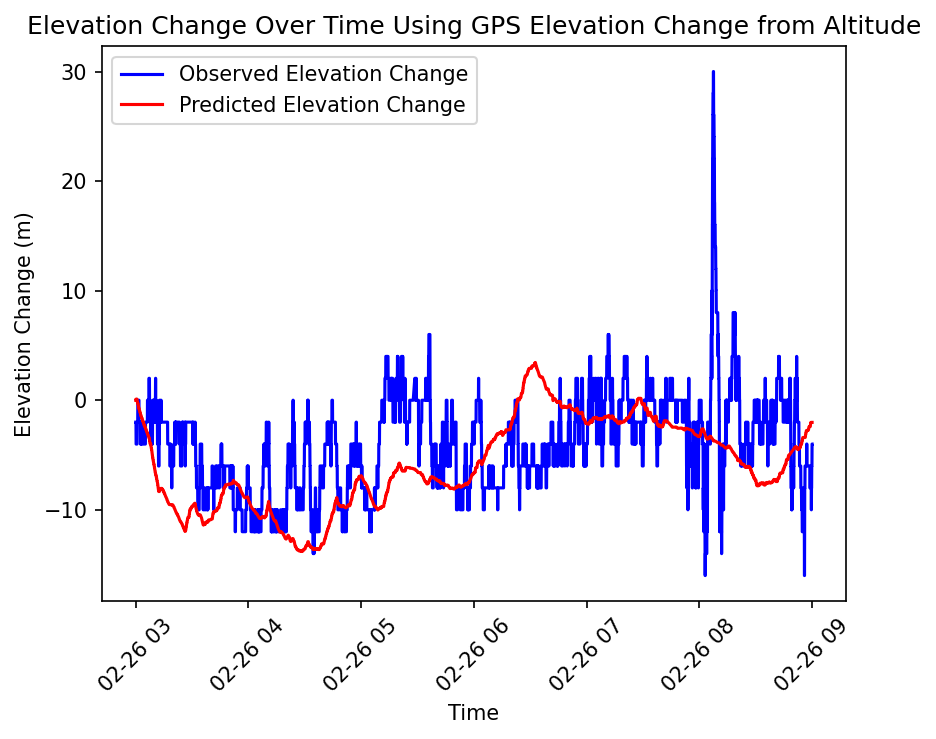

In [44]:
# Plot observed and predicted elevation change
obs_delta = dists_slopes[dists_slopes['cum_delta_elev_msl'].notna()]['cum_delta_elev_msl']
obs_dt = dists_slopes[dists_slopes['cum_delta_elev_msl'].notna()]['datetime']
pred_delta = dists_slopes['cum_delta_elev_acc']
pred_dt = dists_slopes['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_delta, linestyle='-', color='b', label='Observed Elevation Change')
ax.plot(pred_dt, pred_delta,linestyle='-', color='r', label='Predicted Elevation Change')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Elevation Change (m)')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Elevation Change Over Time Using GPS Elevation Change from Altitude')
ax.legend()

# Show plot
plt.show()

## Estimate Energy Expenditure
- Energy expenditure can be estimated using the same activation-relaxation cycling model (ARC model) employed by Berti et al. under the ENERSCAPE framework
- According to the ARC model, the energetic cost of transport is a function of distance traveled, slope of the ground, and body mass of the animal. Distance traveled and slope of the ground can be obtained using the algorithm above.

In [45]:
# Set body mass
body_mass = 200

# Get distance traveled and slope
dist = np.array(dists_slopes['distance_traveled'].iloc[1:])
slope = np.array(dists_slopes['slope_acc'].iloc[0:-1])

# Get distance traveled using equation from ENERSCAPE
term1 = 8 * math.pow(body_mass,-0.34)
term2 = 50 * (1 + np.sin(2*slope-(74*math.pi/180))) * math.pow(body_mass,-0.12)
Ecot = term1 + term2
E = Ecot * body_mass * dist / 4184
dists_slopes['energy_msl'] = np.append([0],E)
dists_slopes['cum_energy_msl'] = dists_slopes['energy_msl'].cumsum()

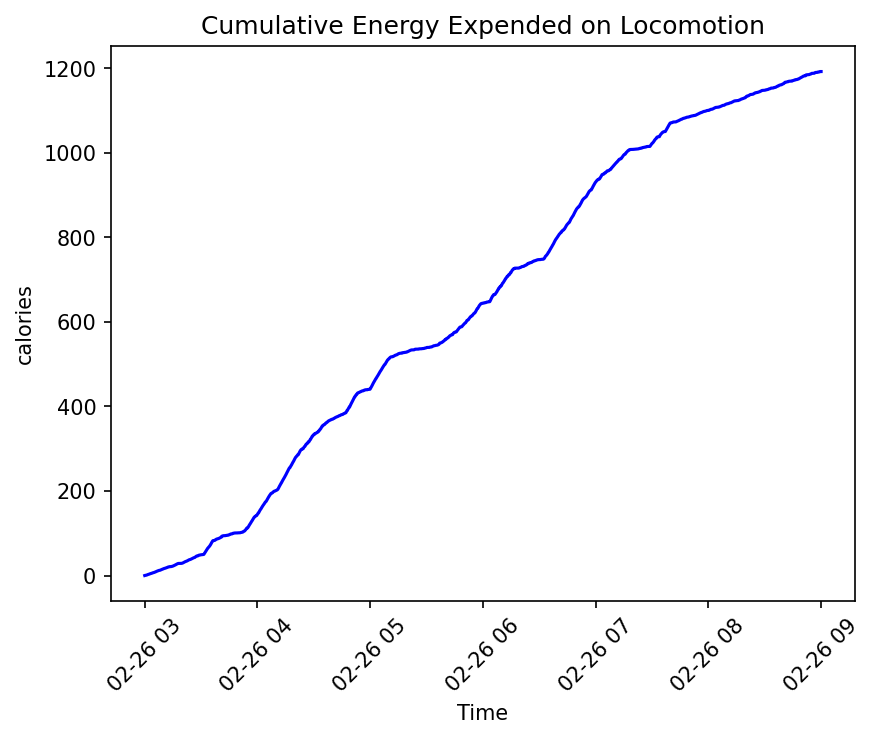

In [47]:
# PLOT CUMULATIVE ENERGY EXPENDITURE

energy = dists_slopes['cum_energy_msl']
#energy = steps['distance_traveled']
dt = dists_slopes['datetime']

# Create a 3D plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the trajectory
ax1.plot(dt, energy, linestyle='-', color='blue', label='Cumulative Energy Expenditure')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax1.set_xlabel('Time')
ax1.set_ylabel('calories')

# Adding a title and legend
ax1.set_title('Cumulative Energy Expended on Locomotion')
ax.legend()

# Show plot
plt.show()